# Statistische Kalibration Time-To-Digital Converter

## Verteilungen

----

#### Prof. Christian Münker, 14. Juni 2017

In [1]:
from __future__ import print_function, division
#show plot in notebook instead of separate windows:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, pi
import scipy
import scipy.stats

#plt.style.use('seaborn-whitegrid')
plt.style.use('classic')#('seaborn-dark')
plt.rcParams['figure.figsize'] = (12.0, 5.0) # Plotgröße in Inch
#print(plt.style.available) # alle Matplotlib styles

In [2]:
# globale Variablen
N = 140      # Anzahl der Verzögerungselemente (Bins)
L = 2**14    # Anzahl der Messungen (= Versuche)
T_max = 2e-9 # maximale Messdauer einer Verzögerungskette

T_bin = T_max / N # durchschnittliche Verzögerung eines Elements
p_i = 1./N   # mittlere Wahrscheinlichkeit das Bin i zu treffen


# Statistische Kalibration
Nicht immer ist es möglich, Testsignale mit genau bestimmten vorhersagbaren (deterministischen) Eigenschaften zu generieren. Manchmal kann man statt dessen zufällig verteilte Testsignale verwenden wenn deren statistische Momente bekannt sind und man die Zielgröße aus Häufigkeiten herauslesen kann.




## Stichproben aus Zufallsverteilungen (Sampling from Distributions) #
----

Mit unendlich vielen Daten würde man theoretisch eine perfekte Auflösung erzielen. So viel Zeit hat man i.A. nicht und muss sich statt dessen mit einer *Stichprobe* begnügen und daraus die Eigenschaften der Verteilung *schätzen*. Eine der wichtigsten Fragen ist daher, welches Vertrauen man in die Ergebnisse setzen kann, also mit welcher Wahrscheinlichkeit das Ergebnis dem für unendlich viele Messwerte entspricht.

In `scipy.stat` kann man für alle Verteilungen mit der Methode `rvs()` (*random variates*) Stichproben beliebiger Größe (parameter `size`) erzeugen. Die Stichproben sind (pseudo-)zufällig, d.h. jedes Mal werden neue Ergebnisse produziert. Je nach Verteilung können weitere Parameter angegeben werden wie `loc` (Mittelwert) oder `p` (Wahrscheinlichkeit).

## Bernoulli-Verteilung ##
 
Kann eine Zufallsvariable bei einem Versuch nur die Werte 0 oder 1 annehmen, $Y_i \in [0,1]$, und ist die Wahrscheinlichkeit für einen "Erfolg" $p = P(Y_i = 1)$ konstant, dann ist $Y_i$ eine *Bernoulli-Verteilung*. 

Beispiele: 
- Münzwurf ("Kopf", $p = 0.5$)
- Würfel ("Sechs", $p = 1/6$)
- TDC mit $N$ gleich breiten Bins, die den Zeitbereich $0 \ldots T_0$ abdecken. Das zu messende Zeitintervall ist eine kontinuierliche, gleichverteilte Größe $T_M \in [0 \ldots T_0]$. Die Wahrscheinlichkeit Bin $i$ zu treffen ist $p = 1/N$. 

Die komplementäre Wahrscheinlichkeit ("Misserfolg") ist definiert als $q = P(Y_i = 0) = 1 - p$.

`bern = scipy.stats.bernoulli(p=1/N)` definiert die Verteilung (*frozen distribution* da der Parameter `p` bereits festgelegt ist).

Mit `bern.rvs(size = 1000)` generiert man eine Stichprobe mit der angegebenen Verteilung und 1000 Elementen.

Der folgende Code zeigt ein Beispiel für eine Stichprobe der Größe 10 aus einer Bernoulli - Verteilung mit der Wahrscheinlichkeit `p=0.2`. Man erwartet ("Erwartungswert"), dass 2 von `L=10` Versuchen erfolgreich waren. Der Erwartungswert lässt sich hier einfach berechnen mit $E<Y_i> = pL$.

Das ist auch oft so, es kann allerdings auch passieren, dass alle Ergebnisse erfolgreich waren. Wie man die Wahrscheinlichkeit dieses Falls abschätzen, werden wir später sehen.


In [3]:
size = 10 # Stichprobengröße
p = 0.2   # Wahrscheinlichkeit
np.set_printoptions(formatter={'float': '{: 0.3f}'.format}) # set print format: 3 Nachkommastellen

bern = scipy.stats.bernoulli(p=p)
x_bern = bern.rvs(size = size)
m_bern = bern.mean()

print("Stichprobe:\t\t{0}".format(x_bern))
print("Erwartungswert:\t{0} \t(Mittelwert der Stichprobe: {1})".format(m_bern, np.sum(x_bern)/size)) # alternativ np.mean(x_bern)


Stichprobe:		[0 1 0 1 1 0 0 0 0 0]
Erwartungswert:	0.2 	(Mittelwert der Stichprobe: 0.3)


## Binomialverteilung ##
Wenn ich $L$ Bernoulli-Versuche mit konstanter Erfolgswahrscheinlichkeit $p$ ausführe und zähle, wie oft das Experiment erfolgreich war, erhalte ich eine neue diskrete Zufallsvariable $S_i = \sum_{k=0}^L$, mit einer *Binomialverteilung*.

Der folgende Code zeigt ein Beispiel für eine Stichprobe mit Größe `size` aus einer Binomialverteilung. Jeder einzelne Wert der Stichprobe ist das Resultat aus 1000 unabhängigen Bernoulli-Experimenten (Bernoulli-Prozess) mit der Wahrscheinlichkeit $p=0.2$.


In [4]:
L = 1000  # Anzahl der Versuche
binom = scipy.stats.binom(n = L, p = p)
x_binom = binom.rvs(size=size)
m_binom = binom.mean()
print("Stichprobe:\t\t{0}".format(x_binom))
print("Erwartungswert = {0} \t(Mittelwert der Stichprobe: {1})".format(m_binom, np.sum(x_binom)/size))


Stichprobe:		[196 212 171 215 195 204 185 207 193 192]
Erwartungswert = 200.0 	(Mittelwert der Stichprobe: 197.0)


Man sieht, dass die Ergebnisse um den erwarteten Mittelwert schwanken. Interessant ist hier, *wie stark* die Ergebnisse schwanken bzw. wie groß die Wahrscheinlichkeit ist, dass ein Ergebnis in einem bestimmten Intervall liegt.

Die Wahrscheinlichkeit, dass sich bei einer Folge von $L$ gleichartigen und unabhängigen Bernoulli-Versuchen mit der Wahrscheinlichkeit $p$ $K$ Erfolge einstellen, wird durch eine Binomialverteilung mit den Parametern $L$ und $p$ angegeben:

$
P(K, L, p) = \binom{L}{K} p^K q^{L-K} = \frac{L!}{K!(L-K)!} p^K q^{L-K} \text{ mit } K \in \mathbb{N}_0
$

Der Erwartungs- oder Mittelwert ist gegeben durch

$E(K) = \mu = pL$

und die Varianz durch

$Var(K) = \sigma^2 = pqL = p(p-1)L$ .

Händisch lässt sich $P(K, L, p)$ für größere $K, L$ kaum noch berechnen. In Python wird die Wahrscheinlichkeit durch die *probability mass function* `binom.pmf(K)` bestimmt, ansonsten kann man für $\sigma > 3$ die Binomialverteilung mit guter Genauigkeit durch die Normalverteilung annähern.




Mittelwert:	40
Std.abweichung:	5.66
Varianz:	32


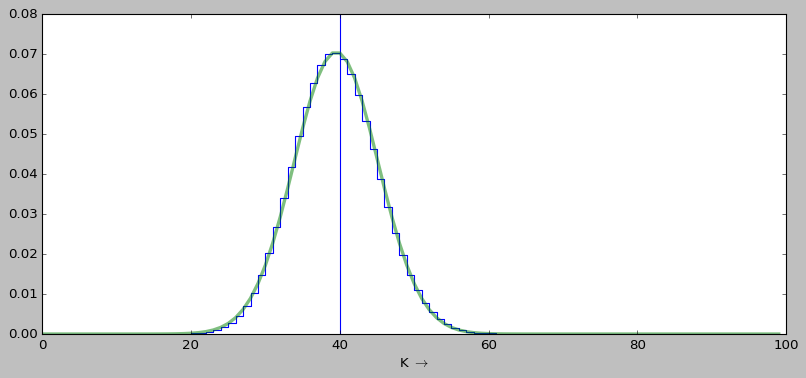

In [5]:
binom = scipy.stats.binom(n = 200, p = p)
K = np.arange(0, 100)
p_binom = binom.pmf(K)
m_binom = binom.mean()
s_binom = binom.std()
print("Mittelwert:\t{0:.3g}".format(m_binom))
print("Std.abweichung:\t{0:.3g}".format(binom.std()))
print("Varianz:\t{0:.3g}".format(binom.var()))
plt.step(K, p_binom)
plt.axvline(x=m_binom)
plt.xlabel(r"K $\rightarrow$")

norm = scipy.stats.norm(loc = m_binom, scale = s_binom) # "frozen" distribution mit m und sigma
p_norm = norm.pdf(K+0.5) # continuous distribution, berechne probability density function
plt.plot(K, p_norm, lw = 3, alpha = 0.5)
plt.show()


Die Wahrscheinlichkeit dafür dass $S_i$ z.B. maximal 50 ist, erhält man aus der Verteilungsfunktion (*cumulative distribution function*, cdf). Diese Funktion lässt sich nicht geschlossen angeben, aber gut durch eine Fehlerfunktion annähern, wenn (Faustregel) die Varianz größer als 9 bzw. die Standardabweichung > 3 ist. Das ist in dem Beispiel hier gegeben. Die Verteilungsfunktionen in Python erhält man über die Methoden
`stats.binom.cdf()` bzw.
`stats.norm.cdf()`.

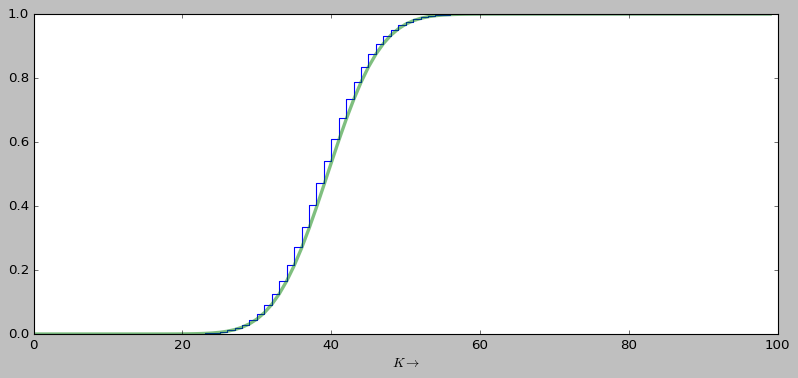

In [6]:
c_binom = binom.cdf(K)
plt.step(K, c_binom)
plt.xlabel(r"$K \rightarrow$")

norm = scipy.stats.norm(loc = m_binom, scale = s_binom) 
c_norm = norm.cdf(K+0.5) # continuous distribution
plt.plot(K, c_norm, lw = 3, alpha = 0.5)
plt.show()

Die Frage am Anfang des Kapitels war ja: Wie groß ist die Wahrscheinlichkeit, dass 10 von 10 Experimenten einer Bernoulli - Verteilung mit $p = 0.2$ erfolgreich sind? Die mathematische Beschreibung ist 

$
P(K, L, p) = \binom{L}{K} p^K q^{L-K} = \frac{L!}{K!(L-K)!} p^K q^{L-K}
$
mit $K = L = 10$. Es ist also $P(K=10, L=10, p=0.2) = 0.2^{10} = 1.024 \cdot 10^{-7}$

oder in Python: 

In [7]:
print("P(p=0.2, K=10, L=10) = 0.2^10\t= {0:g}".format(0.2**10))
print("binom.pmf(p=0.2, n=10, k=10) \t= {0:g}".format(scipy.stats.binom.pmf(p=0.2, n=10, k=10)))

P(p=0.2, K=10, L=10) = 0.2^10	= 1.024e-07
binom.pmf(p=0.2, n=10, k=10) 	= 1.024e-07


## Zufallszahlengenerator ##
Ein Generator soll zunächst gleichverteilte Zufallszahlen im Bereich 1 ... 140 erzeugen. Die Auftretenswahrscheinlichkeit $P_i$ der einzelnen Zahlen $i$ soll mit $L$ Versuchen mit einem Histogramm mit $N = 140$ Bins geschätzt werden (der Erwartungswert ist hier einfach $E<Y_i> = L/N$). Dann soll die Wahrscheinlichkeit bestimmt werden, dass

a) ein Bin die Häufigkeit $E \pm 10 \%$ enthält und

b) *alle* Bins Zahlen im Bereich  $E \pm 10 \%$ enthalten sind

c) welches Sigma hat die Kalibration in Abhängigkeit von $L$ bei $N = 110$?

Sigma in mm aufgrund von Kalibration 

d) inhomogenen Delays ?

e) INL bei inhomogenen Delays? Nach Kalibration? 

f) "5 s" Fehler

g) Vergleichbar mit "Soft Error"

Erwartungswert E =	7.3143 	(aus Stichprobe: 7.45) Counts
Std.abweichung Sigma =	5.657 Counts

0.0005% - 99.9995% Quantile 	= 0 - 22 Counts
Minimum - Maximum (Stichprobe)	= 2 - 16 Counts
Delta (E - Min) bzw. (Max - E) 	= 8.686  Counts	(Delta / Sigma = 1.535)
n_sum = 1043


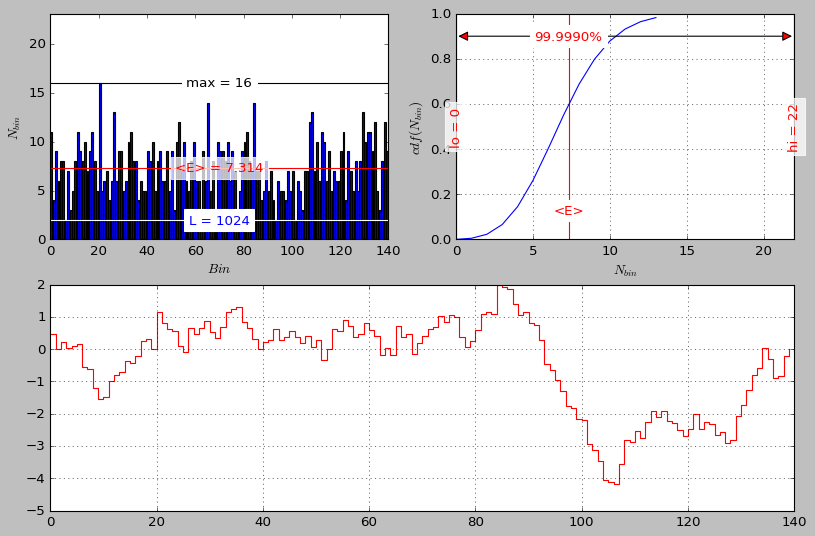

In [45]:
#T = 2.e-9 # System Clock
L = 2**10  # Anzahl der Einzelmessungen
N = 140     # Anzahl der Bins, in die die Messungen fallen
p = 1./N    # Wahrscheinlichkeit, dass das zu messende Zeitintervall in ein bestimmtes Bin fällt

# Definiere Binomialverteilung mit p = 1/N und L Bernoulli-Versuchen (= Einzelmessungen) -> "Hits" für 1 Bin
binom = scipy.stats.binom(n = L, p = p)
size = N#int(L/N) # Stichprobengröße für Binomialverteilung
# Stichprobe mit size Versuchsreihen einer Binomialverteilung für ein einzelnes Bin / eine Versuchsreihe für N Bins:
x_binom = binom.rvs(size=size)
mean = binom.mean() # Erwartungswert
std = binom.std()   # Standardabweichung 
n_sum = np.sum(x_binom) # Anzahl der Einzelmessungen, zurückgerechnet aus der Summe der Stichproben
# Quantile: Berechne die Bins bin_lo bzw. bin_hi, unterhalb derer der Anteil quant_lo bzw. quant_hi = 1 - quant_lo liegen
perc = 0.99999
quant_lo = (1 - perc)/2.; quant_hi = 1 - quant_lo # unteres bzw. oberes Quantil
bin_lo = binom.ppf(quant_lo);  bin_hi = binom.ppf(quant_hi) # untere bzw. obere Grenzen
#
N_bins = np.arange(2 * int(mean)) # array mit "Hits" = Anzahl der Messungen in einem Bin von 0 bis 2*Erwartungswert
cdf = binom.cdf(N_bins) # kumulierte Wahrscheinlichkeitsdichte
#print("Binomialverteilung:", x_binom)
print("Erwartungswert E =\t{0:.5g} \t(aus Stichprobe: {1:.5g}) Counts".format(mean, np.sum(x_binom)/N))
print("Std.abweichung Sigma =\t{0:.4g} Counts\n".format(s_binom))
print("{0:.4%} - {1:.4%} Quantile \t= {2:g} - {3:g} Counts".format(quant_lo, quant_hi, bin_lo, bin_hi))
print("Minimum - Maximum (Stichprobe)\t= {0:d} - {1:d} Counts".format(min(x_binom), max(x_binom)))
Delta_max  = max(mean - min(x_binom), max(x_binom) - mean)
print("Delta (E - Min) bzw. (Max - E) \t= {0:.4g}  Counts\t(Delta / Sigma = {1:.4g})".format(Delta_max, Delta_max/s_binom))
print("n_sum = {0:g}".format(n_sum))
fig1 = plt.figure(1, figsize =(12,12))
ax1 = fig1.add_subplot(321) 
ax1.bar(range(N), x_binom)
ax1.axhline(y=mean, color='r')
ax1.text(N/2., mean, '<E> = {0:.4g}'.format(mean), color='r', ha='center', va='center', backgroundcolor=(1,1,1,0.75))
ax1.axhline(y=min(x_binom), color='w')
ax1.text(N/2., min(x_binom), 'min = {0}'.format(min(x_binom)), color='w', ha='center', va='top')
ax1.axhline(y=max(x_binom), color='k')
ax1.text(N/2., max(x_binom), 'max = {0}'.format(max(x_binom)), color='k', ha='center', va='center', backgroundcolor='w')
ax1.text(N/2., 0.1 * max(x_binom), 'L = {0}'.format(L), color='b', backgroundcolor='w', ha='center')
ax1.set_xlabel(r"$Bin$"); ax1.set_ylabel(r"$N_{bin}$")
ax1.set_ylim(0, max(bin_hi, max(x_binom)) * 1.05)
ax2 = fig1.add_subplot(322)
ax2.set_xlim(bin_lo * 0.75, bin_hi + bin_lo*0.25)
ax2.axvline(x=bin_lo, color = 'r'); ax2.axvline(x=mean, color = 'r'); ax2.axvline(x=bin_hi, color = 'r')
ax2.axvspan(0, bin_lo, facecolor='r', alpha=.2); ax2.axvspan(bin_hi, L, facecolor='r', alpha=.2)
ax2.text(mean, 0.1, '<E>', ha='center', va='bottom', color='r', backgroundcolor='w') # rotation=90,
ax2.text(bin_lo, 0.5, 'lo = {0:g}'.format(bin_lo), color='r', ha='center', va='center', backgroundcolor=(1,1,1,0.75), 
         rotation=90)
ax2.text(bin_hi, 0.5, 'hi = {0:g}'.format(bin_hi), color='r', ha='center', va='center', backgroundcolor=(1,1,1,0.75), 
         rotation=90)
    # double-headed arrow for period length using annotate command with empty text:
ax2.annotate('', (bin_lo, 0.9),(bin_hi, 0.9), xycoords='data', ha="center", va="center", size=18,
        arrowprops=dict(arrowstyle="<|-|>", facecolor = 'red', edgecolor='black' ))
ax2.text(mean, 0.9, '{0:.4%}'.format(perc), color='r', ha='center', va='center', backgroundcolor=(1,1,1,1))
ax2.set_xlabel(r"$N_{bin}$"); ax2.set_ylabel(r"$cdf(N_{bin})$")
ax2.grid(True)
ax2.plot(N_bins, cdf)

#hist, bin_hist = np.histogram(x_binom, bins = N) 
hist_acc = np.cumsum(x_binom) # Accumulate histogram values and ...
hist_acc = hist_acc / hist_acc[-1] * N # scale in such a way that the last accumulated bin = N
ax3 = fig1.add_subplot(312); ax3.grid(True)
#ax3.step(range(N), hist_acc, 'b', where="post", label="Accumulated Histogram")
ax3.step(range(N), hist_acc - range(1,N+1), 'r', where="post", label="Delta")
fig3.tight_layout()
plt.show()

Durch Akkumulieren des Histogramms erhält man die Quantisierungskennline, Zeit über Bin:

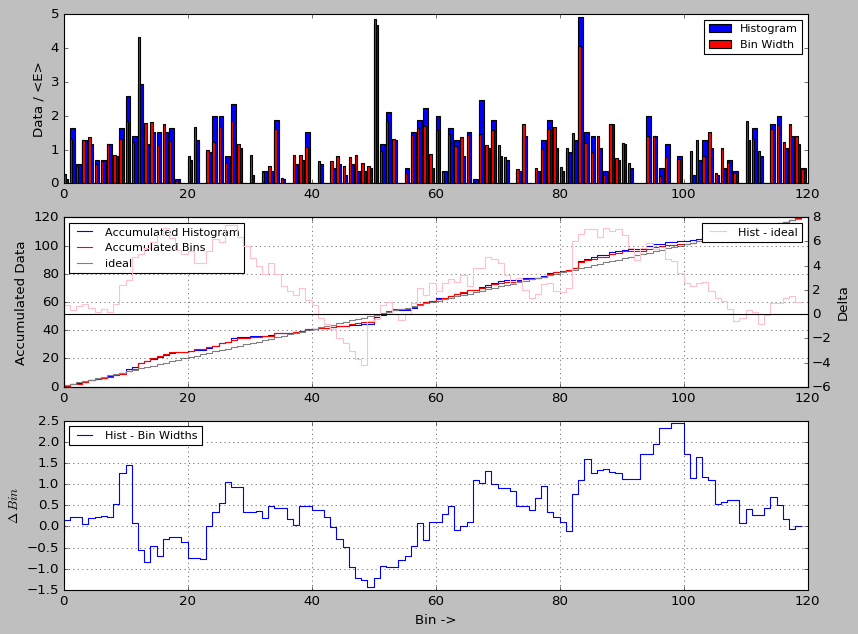

In [43]:
N = 120 # number of bins
T0 = 2e-9 # clock period
norm = scipy.stats.uniform() # uniform distribution
x_norm = norm.rvs(size=L) * N # L samples in the range 0 ... N
bin_widths = np.clip(np.random.rand(N) - 0.1, 0, 1000) * 3 # calculate N bins in the range 0 ... 2 with additional zero bins
uw_bins = [[12, 6.3], [50,7.1], [83, 5.9]]
for b in uw_bins:
    bin_widths[b[0]] = b[1]
bin_edges = np.cumsum(bin_widths) # calculate bin edges by accumulating the bins ...
bin_edges = np.insert(bin_edges, 0, 0) #  ... add left most edge = 0 (-> N+1 edges) and .. 
bin_edges = bin_edges * N / bin_edges[-1] # .... scale all bins so that the right-most edge = N
E_hist = L/N # Expectation value histogram
E_bins = np.mean(bin_widths) # Expectation value bin width (uniform distribution)
#print(bin_widths)
#print(bin_edges)
# histogram() returns (values, edges). len(edges) = len(hist) + 1. When edges are specified, bin_hist = bin_edges:
hist, bin_hist = np.histogram(x_norm, bins = bin_edges) 
hist_acc = np.cumsum(hist) # Accumulate histogram values and ...
hist_acc = hist_acc / hist_acc[-1] * N # scale in such a way that the last accumulated bin = N
#print(len(hist), hist[-1])
#print(max(x_norm))

fig3 = plt.figure(3, figsize=(12.0, 9.0))
ax11 =  fig3.add_subplot(311)
#ax12 = ax11.twinx()
ax11.bar(range(N), hist/E_hist, label="Histogram") # 
ax11.bar(range(N), bin_widths/E_bins, width = 0.4, color="red", label="Bin Width")
ax11.set_ylabel("Data / <E>")
#ax12.set_ylabel("Bin Width")
ax11.legend(loc='best', fontsize=10)
#
ax21 = fig3.add_subplot(312); ax21.grid(True)
ax21.step(range(N), hist_acc, 'b', where="post", label="Accumulated Histogram")
ax21.step(range(N), bin_edges[1:], 'r', where="post", label="Accumulated Bins")
ax21.step(range(N), range(N), color='0.5', label="ideal")
ax21.set_ylabel("Accumulated Data")
ax22 = ax21.twinx()
ax22.step(range(N), hist_acc - range(N), color="pink", label="Hist - ideal")
ax22.axhline(y=0, color='k')
ax22.set_ylabel("Delta")
ax22.legend(loc='best', fontsize=10)
ax21.legend(loc='best', fontsize=10)
#
ax31 = fig3.add_subplot(313); ax31.grid(True)
ax31.step(range(N), hist_acc - bin_edges[1:], label="Hist - Bin Widths")
#ax31.step(range(N), hist_acc - range(N), label="Hist - ideal")
ax31.set_xlabel("Bin ->")
ax31.set_ylabel(r"$\Delta \, Bin$")
ax31.legend(loc='best', fontsize=10);


In [30]:
#np.histogram?